In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

In [4]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [5]:
Smarket = load_data('Smarket')
Smarket

Year   Lag1   Lag2   Lag3   Lag4   Lag5   Volume  Today Direction
0     2001  0.381 -0.192 -2.624 -1.055  5.010  1.19130  0.959        Up
1     2001  0.959  0.381 -0.192 -2.624 -1.055  1.29650  1.032        Up
2     2001  1.032  0.959  0.381 -0.192 -2.624  1.41120 -0.623      Down
3     2001 -0.623  1.032  0.959  0.381 -0.192  1.27600  0.614        Up
4     2001  0.614 -0.623  1.032  0.959  0.381  1.20570  0.213        Up
...    ...    ...    ...    ...    ...    ...      ...    ...       ...
1245  2005  0.422  0.252 -0.024 -0.584 -0.285  1.88850  0.043        Up
1246  2005  0.043  0.422  0.252 -0.024 -0.584  1.28581 -0.955      Down
1247  2005 -0.955  0.043  0.422  0.252 -0.024  1.54047  0.130        Up
1248  2005  0.130 -0.955  0.043  0.422  0.252  1.42236 -0.298      Down
1249  2005 -0.298  0.130 -0.955  0.043  0.422  1.38254 -0.489      Down

[1250 rows x 9 columns]

In [6]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [8]:
Smarket.corr(numeric_only=True)

Year      Lag1      Lag2  ...      Lag5    Volume     Today
Year    1.000000  0.029700  0.030596  ...  0.029788  0.539006  0.030095
Lag1    0.029700  1.000000 -0.026294  ... -0.005675  0.040910 -0.026155
Lag2    0.030596 -0.026294  1.000000  ... -0.003558 -0.043383 -0.010250
Lag3    0.033195 -0.010803 -0.025897  ... -0.018808 -0.041824 -0.002448
Lag4    0.035689 -0.002986 -0.010854  ... -0.027084 -0.048414 -0.006900
Lag5    0.029788 -0.005675 -0.003558  ...  1.000000 -0.022002 -0.034860
Volume  0.539006  0.040910 -0.043383  ... -0.022002  1.000000  0.014592
Today   0.030095 -0.026155 -0.010250  ... -0.034860  0.014592  1.000000

[8 rows x 8 columns]

In [9]:
Smarket.isnull().sum()

Year         0
Lag1         0
Lag2         0
Lag3         0
Lag4         0
Lag5         0
Volume       0
Today        0
Direction    0
dtype: int64

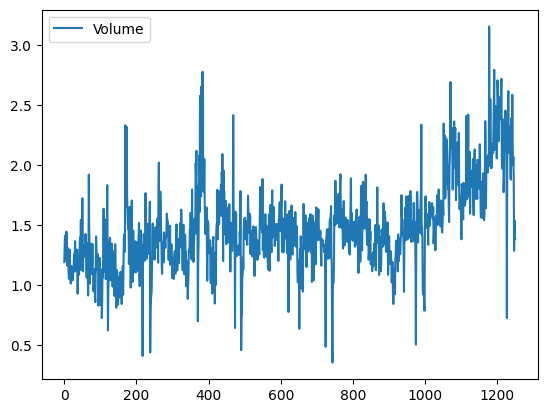

In [ ]:
Smarket.plot(y='Volume')

In [11]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

coef  std err      z  P>|z|
intercept -0.1260    0.241 -0.523  0.601
Lag1      -0.0731    0.050 -1.457  0.145
Lag2      -0.0423    0.050 -0.845  0.398
Lag3       0.0111    0.050  0.222  0.824
Lag4       0.0094    0.050  0.187  0.851
Lag5       0.0103    0.050  0.208  0.835
Volume     0.1354    0.158  0.855  0.392

In [12]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [13]:
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [14]:
prob = results.predict()

In [15]:
prob[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [16]:
labels = np.array(['Down']*1250)
labels[prob>0.5] = 'Up'

In [17]:
labels

array(['Up', 'Down', 'Down', ..., 'Up', 'Up', 'Up'], dtype='<U4')

In [18]:
confusion_table(labels, Smarket.Direction)


Truth      Down   Up
Predicted           
Down        145  141
Up          457  507

In [ ]:
(507+145)/1250, np.mean(labels == Smarket.Direction)

(0.5216, np.float64(0.5216))

In [20]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]
print(Smarket_test.shape)
print(Smarket_train.shape)

(252, 9)
(998, 9)


In [21]:

X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [22]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [23]:
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth      Down  Up
Predicted          
Down         77  97
Up           34  44

In [24]:
np.mean(labels == L_test), np.mean(labels != L_test)


(np.float64(0.4801587301587302), np.float64(0.5198412698412699))

In [26]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)
labels = np.array(['Down']*252)
labels[probs>0.5] = 'Up'
confusion_table(labels, L_test)

Truth      Down   Up
Predicted           
Down         35   35
Up           76  106

In [27]:
(35+106)/252,106/(106+76)

(0.5595238095238095, 0.5824175824175825)

In [28]:
newdata = pd.DataFrame({'Lag1':[1.2, 1.5],
                        'Lag2':[1.1, -0.8]});
newX = model.transform(newdata)
results.predict(newX)

0    0.479146
1    0.496094
dtype: float64

**LDA**

In [29]:
lda = LDA(store_covariance=True)

In [30]:
X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [32]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [33]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [34]:
lda.priors_

array([0.49198397, 0.50801603])

In [35]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [36]:
lda_pred = lda.predict(X_test)

In [43]:
confusion_table(lda_pred,L_test)

Truth      Down   Up
Predicted           
Down         35   35
Up           76  106

In [46]:
lda_prob = lda.predict_proba(X_test)
np.all(
    np.where(lda_prob[:,1] >= 0.5, 'Up','Down') == lda_pred
)

np.True_

In [47]:
np.all(
       [lda.classes_[i] for i in np.argmax(lda_prob, 1)] == lda_pred
       )

np.True_

In [56]:
np.sum(lda_prob[:,0] > 0.9)

np.int64(0)

In [57]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [58]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [59]:

qda.covariance_[0]

array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]])

In [60]:

qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth      Down   Up
Predicted           
Down         30   20
Up           81  121

In [61]:
np.mean(qda_pred == L_test)

np.float64(0.5992063492063492)

**Naive Bayes**

In [62]:
NB = GaussianNB()
NB.fit(X_train, L_train)

GaussianNB()

In [63]:

NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [64]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [65]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [66]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [67]:
X_train[L_train == 'Down'].mean()

Lag1    0.042790
Lag2    0.033894
dtype: float64

In [68]:
X_train[L_train == 'Down'].var(ddof=0)

Lag1    1.503554
Lag2    1.532467
dtype: float64

In [69]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth      Down   Up
Predicted           
Down         29   20
Up           82  121

In [70]:
NB.predict_proba(X_test)[:5]

array([[0.4873288 , 0.5126712 ],
       [0.47623584, 0.52376416],
       [0.46529531, 0.53470469],
       [0.47484469, 0.52515531],
       [0.49020587, 0.50979413]])

In [71]:
knn1 = KNeighborsClassifier(n_neighbors=1)
X_train, X_test = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth      Down  Up
Predicted          
Down         43  58
Up           68  83

In [72]:

(83+43)/252, np.mean(knn1_pred == L_test)

(0.5, np.float64(0.5))

In [73]:

knn3 = KNeighborsClassifier(n_neighbors=3)
knn3_pred = knn3.fit(X_train, L_train).predict(X_test)
np.mean(knn3_pred == L_test)

np.float64(0.5317460317460317)

In [74]:
Caravan = load_data('Caravan')
Purchase = Caravan.Purchase
Purchase.value_counts()

Purchase
No     5474
Yes     348
Name: count, dtype: int64

In [93]:
Caravan

MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  ...  AFIETS  AINBOED  ABYSTAND  Purchase
0          33         1        3         2  ...       0        0         0        No
1          37         1        2         2  ...       0        0         0        No
2          37         1        2         2  ...       0        0         0        No
3           9         1        3         3  ...       0        0         0        No
4          40         1        4         2  ...       0        0         0        No
...       ...       ...      ...       ...  ...     ...      ...       ...       ...
5817       36         1        1         2  ...       0        0         0        No
5818       35         1        4         4  ...       0        0         0        No
5819       33         1        3         4  ...       0        0         0       Yes
5820       34         1        3         2  ...       0        0         0        No
5821       33         1        3         3  ...       0        0         0        No

[5822 rows x 86 columns]

In [75]:

348 / 5822

0.05977327378907592

In [77]:

feature_df = Caravan.drop(columns=['Purchase'])
feature_df

MOSTYPE  MAANTHUI  MGEMOMV  MGEMLEEF  ...  APLEZIER  AFIETS  AINBOED  ABYSTAND
0          33         1        3         2  ...         0       0        0         0
1          37         1        2         2  ...         0       0        0         0
2          37         1        2         2  ...         0       0        0         0
3           9         1        3         3  ...         0       0        0         0
4          40         1        4         2  ...         0       0        0         0
...       ...       ...      ...       ...  ...       ...     ...      ...       ...
5817       36         1        1         2  ...         0       0        0         0
5818       35         1        4         4  ...         0       0        0         0
5819       33         1        3         4  ...         0       0        0         0
5820       34         1        3         2  ...         0       0        0         0
5821       33         1        3         3  ...         0       0        0         0

[5822 rows x 85 columns]

In [78]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)

In [79]:
scaler.fit(feature_df)
X_std = scaler.transform(feature_df)

In [81]:
X_std

array([[ 0.68090623, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.99229684, -0.27257995, -0.85950007, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.99229684, -0.27257995, -0.85950007, ..., -0.15062046,
        -0.08734772, -0.11881647],
       ...,
       [ 0.68090623, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.75875388, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647],
       [ 0.68090623, -0.27257995,  0.40669664, ..., -0.15062046,
        -0.08734772, -0.11881647]])

In [82]:
feature_std = pd.DataFrame(
                 X_std,
                 columns=feature_df.columns);
feature_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [83]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(np.asarray(feature_std),
                            Purchase,
                            test_size=1000,
                            random_state=0)

In [84]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

(np.float64(0.111), np.float64(0.067))

In [85]:
confusion_table(knn1_pred, y_test)

Truth       No  Yes
Predicted          
No         880   58
Yes         53    9

In [86]:
9/(53+9)

0.14516129032258066

In [89]:
for K in range(1,6):
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to rent: {1:>2},' +
            '  # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc['Yes'].sum()
    did_rent = C.loc['Yes','Yes']
    print(templ.format(
          K,
          pred,
          did_rent,
          did_rent / pred))

K=1: # predicted to rent: 62,  # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6,  # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20,  # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4,  # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7,  # who did rent 1, accuracy 14.3%


In [90]:
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_train, y_train)
logit_pred = logit.predict_proba(X_test)
logit_labels = np.where(logit_pred[:,1] > .5, 'Yes', 'No')
confusion_table(logit_labels, y_test)

/Users/quant1wen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/quant1wen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/quant1wen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Truth       No  Yes
Predicted          
No         931   67
Yes          2    0

In [91]:

logit_labels = np.where(logit_pred[:,1]>0.25, 'Yes', 'No')
confusion_table(logit_labels, y_test)

Truth       No  Yes
Predicted          
No         913   58
Yes         20    9

In [92]:
9/(20+9)


0.3103448275862069

**Simple NN**